# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
import sklearn

In [2]:
PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = {k: v for k, v in zip(self.word2vec.keys(), range(nmax))}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))
    
    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        scores = [self.score(w, self.id2word[id]) for id in range(len(w2v.word2vec.keys()))]
        ids = list(np.flip(np.argsort(scores)))
        ids.remove(self.word2id[w])  #w is most similar to itself, so we remove it
        return [self.id2word[id] for id in ids[:K]]

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        v1, v2 = self.word2vec[w1], self.word2vec[w2]
        return np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 200000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['cats', 'kitty', 'kitten', 'feline', 'kitties']
['dogs', 'puppy', 'Dog', 'doggie', 'canine']
['dog', 'pooches', 'Dogs', 'doggies', 'canines']
['france', 'Paris', 'parisian', 'london', 'berlin']
['austria', 'europe', 'german', 'berlin', 'poland']


In [7]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if sent:  #checks if sentence is not an empty list
                if idf is False:
                    sentemb.append(np.mean(np.transpose([self.w2v.word2vec[w] for w in sent]), axis=1))
                else:
                    sentemb.append(np.average([self.w2v.word2vec[w] for w in sent], 
                                          weights=[idf[w] for w in sent], axis=0))
            else:  #if sentence is empty list we set its embedding to 0
                sentemb.append(np.zeros(300))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        scores = [self.score(s, s2, idf) for s2 in sentences]
        ids = np.flip(np.argsort(scores))
        print('Query sentence: '+ ' '.join(s)+'\n')
        print('Top '+str(K)+' most similar sentences:')
        for id in ids[1:K+1]:
            print(' '.join(sentences[id]))


    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        v1, v2 = self.encode([s1,s2], idf)
        return np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        for w in idf.keys():
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
        return idf


In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with io.open(PATH_TO_DATA+'sentences.txt', encoding='utf-8') as f:
    for line in f:
        # we clear every sentence of words that do not appear in crawl-300d-200k.vec
        sentence = [word for word in line.split(' ') if word in w2v.word2vec]
        sentences.append(sentence)
        
# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print('\nSimilarity score between '+'"'+' '.join(sentences[7])+'" and "'+' '.join(sentences[13])+'":')
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])

# Build idf scores for each word
idf = s2v.build_idf(sentences)
print("With IDF weighting:\n")
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)

Loaded 200000 pretrained word vectors
Query sentence: 1 smiling african american boy .

Top 5 most similar sentences:
an african american man smiling .
a little african american boy and girl looking up .
an american woman standing behind two small african american children .
an african american man is sitting .
a girl in black hat holding an african american baby .

Similarity score between "1 man singing and 1 man playing a saxophone in a concert ." and "10 people venture out to go skiing .":
With IDF weighting:

Query sentence: 1 smiling african american boy .

Top 5 most similar sentences:
an african american man smiling .
an african american man is sitting .
a little african american boy and girl looking up .
an american woman standing behind two small african american children .
a girl in black hat holding an african american baby .


0.47514508753687823

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
#words are columns in the matrix
common_words = [w for w in w2v_en.word2vec.keys() if w in w2v_fr.word2vec.keys()]
X = np.concatenate([w2v_fr.word2vec[w].reshape(1,-1) for w in common_words], axis=0).T 
Y = np.concatenate([w2v_en.word2vec[w].reshape(1,-1) for w in common_words], axis=0).T 

In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
import scipy.linalg
U, s, Vh = scipy.linalg.svd(Y.dot(X.T))
W = U.dot(Vh)

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
def score(v1, v2):
    return np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    
def most_similar_word(w, w2v_1, w2v_2, embedding):
    vec_1 = w2v_1.word2vec[w]
    vec_2 = embedding.dot(vec_1)
    scores = [score(vec_2, w2v_2.word2vec[w2v_2.id2word[id]]) for id in range(len(w2v_2.word2vec.keys()))]
    ids = list(np.flip(np.argsort(scores)))
    return [w2v_2.id2word[id] for id in ids[:5]]



print("French to English :")
for w in ["gilet", "jaune", "président", "manifestation", "police", "travail", "chômage"]:
    w2 = most_similar_word(w, w2v_fr, w2v_en, W)
    print(w+':', w2)
    
print("\nEnglish to French :")
for w in ["depression", "anxiety", "loneliness"]:
    w2 = most_similar_word(w, w2v_en, w2v_fr, W.T)
    print(w+':', w2)

French to English :
gilet: ['trousers', 'blouse', 'straps', 'jacket', 'sleeves']
jaune: ['yellow', 'yellowish', 'reddish', 'pinkish', 'bluish']
président: ['president', 'chairman', 'vice', 'chairmanship', 'presidents']
manifestation: ['demonstrations', 'protests', 'protest', 'demonstration', 'demonstrators']
police: ['police', 'policemen', 'lapd', 'detectives', 'nypd']
travail: ['work', 'travail', 'unskilled', 'employment', 'labor']
chômage: ['unemployment', 'unemployed', 'incomes', 'wages', 'earners']

English to French :
depression: ['dépression', 'dépressions', 'dépressif', 'ouragan', 'cyclonique']
anxiety: ['anxiété', 'stress', 'anxieux', 'addiction', 'schizophrénie']
loneliness: ['mélancolie', 'solitude', 'tristesse', 'souffrance', 'désespoir']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [263]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

# Load train sentences
train_raw = []
Y_train = []
with io.open(PATH_TO_DATA+'SST/stsa.fine.train', encoding='utf-8') as f:
    for line in f:
        splitted = line.split(' ')
        Y_train.append(int(splitted[0]))
        sentence = [word for word in splitted[1:] if word in w2v.word2vec]
        train_raw.append(sentence)

# Load dev sentences
dev_raw = []
Y_dev = []
with io.open(PATH_TO_DATA+'SST/stsa.fine.dev', encoding='utf-8') as f:
    for line in f:
        splitted = line.split(' ')
        Y_dev.append(int(splitted[0]))
        sentence = [word for word in splitted[1:] if word in w2v.word2vec]
        dev_raw.append(sentence)
        
# Load test sentences
test_raw = []
with io.open(PATH_TO_DATA+'SST/stsa.fine.test.X', encoding='utf-8') as f:
    for line in f:
        sentence = [word for word in line.split(' ') if word in w2v.word2vec]
        test_raw.append(sentence)

Loaded 200000 pretrained word vectors


In [264]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
train_bov = s2v.encode(train_raw, False)
idf_train = s2v.build_idf(train_raw)
train_bov_idf = s2v.encode(train_raw, idf_train)

dev_bov = s2v.encode(dev_raw, False)
idf_dev = s2v.build_idf(train_raw + dev_raw)
dev_bov_idf = s2v.encode(dev_raw, idf_dev)

test_bov = s2v.encode(test_raw, False)
idf_test = s2v.build_idf(train_raw + dev_raw + test_raw)
test_bov_idf = s2v.encode(test_raw, idf_test)

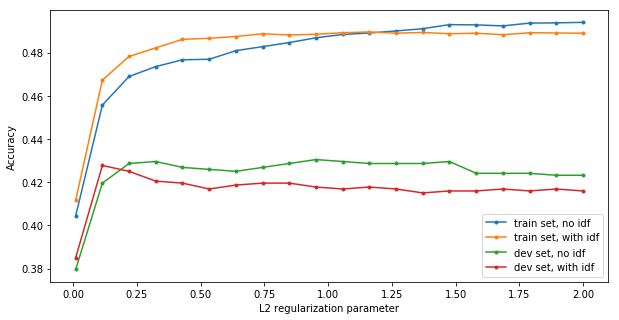

Accuracy on dev set with tuned parameter: 0.4305177111716621
Accuracy on dev set with tuned parameter and idf: 0.4178019981834696


In [265]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# without idf
Cs = np.linspace(10**(-2), 2, 20)
acc_train, acc_dev = [], []
for C in Cs:
    clf = LogisticRegression(penalty="l2", C=C, solver="liblinear", multi_class='ovr')
    clf.fit(train_bov, Y_train)
    acc_train.append(clf.score(train_bov, Y_train))
    acc_dev.append(clf.score(dev_bov, Y_dev))

# with idf
acc_train_idf, acc_dev_idf = [], []
for C in Cs:
    clf = LogisticRegression(penalty="l2", C=C, solver="liblinear", multi_class='ovr')
    clf.fit(train_bov_idf, Y_train)
    acc_train_idf.append(clf.score(train_bov_idf, Y_train))
    acc_dev_idf.append(clf.score(dev_bov_idf, Y_dev))
    
plt.figure(figsize=(10,5))
plt.plot(Cs, acc_train, '.-', label='train set, no idf')
plt.plot(Cs, acc_train_idf, '.-', label='train set, with idf')
plt.plot(Cs, acc_dev, '.-', label='dev set, no idf')
plt.plot(Cs, acc_dev_idf, '.-', label='dev set, with idf')
plt.legend(loc='lower right')
plt.xlabel("L2 regularization parameter")
plt.ylabel("Accuracy")
plt.show()

C_best = Cs[np.argmax(acc_dev)]
C_best_idf = Cs[np.argmax(acc_dev)]
clf = LogisticRegression(penalty="l2", C=C_best, solver="liblinear", multi_class='ovr')
clf_idf = LogisticRegression(penalty="l2", C=C_best_idf, solver="liblinear", multi_class='ovr')
clf.fit(train_bov, Y_train)
clf_idf.fit(train_bov_idf, Y_train)
print('Accuracy on dev set with tuned parameter:', clf.score(dev_bov, Y_dev))
print('Accuracy on dev set with tuned parameter and idf:', clf_idf.score(dev_bov_idf, Y_dev))

In [198]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
Y_pred = clf.predict(test_bov)
np.savetxt('logreg_bov_y_test_sst.txt', Y_pred, fmt='%d', delimiter='\n') #!!remember to delete last newline!!

In [231]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

import xgboost as xgb
dtrain = xgb.DMatrix(train_bov, label=Y_train)
ddev = xgb.DMatrix(dev_bov, label=Y_dev)
param = {'n_estimators': 1000, 'max_depth': 4, 'eta': 0.01,
         'subsample': 1, 'colsample_bytree': 1, 'gamma': 1,
         'objective': 'multi:softmax', 'num_class': 5, 'eval_metric': 'merror',
         'nthread': 8, 'silent': 1}
evallist = [(dtrain, 'train'), (ddev, 'eval')]
num_round = 40
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
print('best accuracy on the dev set:', 1-bst.best_score)

Y_pred = bst.predict(xgb.DMatrix(test_bov), ntree_limit=bst.best_ntree_limit)
np.savetxt('xgb_bov_y_test_sst.txt', Y_pred, fmt='%d', delimiter='\n') #!!remember to delete last newline!!

[0]	train-merror:0.591292	eval-merror:0.653043
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[1]	train-merror:0.585323	eval-merror:0.643052
[2]	train-merror:0.580875	eval-merror:0.641235
[3]	train-merror:0.582982	eval-merror:0.642143
[4]	train-merror:0.574789	eval-merror:0.64396
[5]	train-merror:0.57514	eval-merror:0.645777
[6]	train-merror:0.57081	eval-merror:0.640327
[7]	train-merror:0.567065	eval-merror:0.637602
[8]	train-merror:0.567065	eval-merror:0.642143
[9]	train-merror:0.564607	eval-merror:0.634877
[10]	train-merror:0.561915	eval-merror:0.637602
[11]	train-merror:0.56133	eval-merror:0.637602
[12]	train-merror:0.562383	eval-merror:0.63851
[13]	train-merror:0.559925	eval-merror:0.631244
[14]	train-merror:0.557584	eval-merror:0.62852
[15]	train-merror:0.556882	eval-merror:0.630336
[16]	train-merror:0.555243	eval-merror:0.625795
[17]	train-merror:0.555946	eval-merror:0.627611
[18]	

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [63]:
import keras

Using TensorFlow backend.


In [233]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "./data/"

# TYPE CODE HERE
# Load train sentences
train_raw = []
Y_train = []
with io.open(PATH_TO_DATA+'SST/stsa.fine.train', encoding='utf-8') as f:
    for line in f:
        label, sentence = line.split(' ', 1)
        Y_train.append(int(label))
        train_raw.append(sentence)

# Load dev sentences
dev_raw = []
Y_dev = []
with io.open(PATH_TO_DATA+'SST/stsa.fine.dev', encoding='utf-8') as f:
    for line in f:
        label, sentence = line.split(' ', 1)
        Y_dev.append(int(label))
        dev_raw.append(sentence)
        
# Load test sentences
test_raw = []
with io.open(PATH_TO_DATA+'SST/stsa.fine.test.X', encoding='utf-8') as f:
    for line in f:
        test_raw.append(line)


In [234]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_raw+dev_raw+test_raw)
tokenized = tokenizer.texts_to_sequences(train_raw+dev_raw+test_raw)
train_tok = tokenized[:len(train_raw)]
dev_tok = tokenized[len(train_raw): len(train_raw)+len(dev_raw)]
test_tok = tokenized[len(train_raw)+len(dev_raw): len(train_raw)+len(dev_raw)+len(test_raw)]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [235]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing import sequence
x_train = sequence.pad_sequences(train_tok, maxlen=100)
x_dev = sequence.pad_sequences(dev_tok, maxlen=100)
x_test = sequence.pad_sequences(test_tok, maxlen=100)

## 4.2 - Design and train your model

In [245]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 100  # word embedding dimension
nhid       = 10  # number of hidden units in the LSTM
vocab_size = 1000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))


In [246]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 100)         100000    
_________________________________________________________________
lstm_21 (LSTM)               (None, 10)                4440      
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 55        
Total params: 104,495
Trainable params: 104,495
Non-trainable params: 0
_________________________________________________________________
None


In [247]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64
n_epochs = 5
y_train = keras.utils.np_utils.to_categorical(Y_train)
y_dev = keras.utils.np_utils.to_categorical(Y_dev)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1,
                                               save_best_only=True, monitor='val_acc')
history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev),
                    callbacks=[checkpointer])

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 33s 4ms/step - loss: 1.5689 - acc: 0.2870 - val_loss: 1.5418 - val_acc: 0.3451

Epoch 00001: val_acc improved from -inf to 0.34514, saving model to /tmp/weights.hdf5
Epoch 2/5
8544/8544 [==============================] - 27s 3ms/step - loss: 1.4729 - acc: 0.3646 - val_loss: 1.4425 - val_acc: 0.3760

Epoch 00002: val_acc improved from 0.34514 to 0.37602, saving model to /tmp/weights.hdf5
Epoch 3/5
8544/8544 [==============================] - 27s 3ms/step - loss: 1.3567 - acc: 0.4230 - val_loss: 1.4162 - val_acc: 0.4060

Epoch 00003: val_acc improved from 0.37602 to 0.40599, saving model to /tmp/weights.hdf5
Epoch 4/5
8544/8544 [==============================] - 27s 3ms/step - loss: 1.2902 - acc: 0.4553 - val_loss: 1.4089 - val_acc: 0.4024

Epoch 00004: val_acc did not improve from 0.40599
Epoch 5/5
8544/8544 [==============================] - 27s 3ms/step - loss: 1.2470 - acc: 0.4741 -

In [248]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
model = keras.models.load_model("/tmp/weights.hdf5")
Y_pred = np.argmax(model.predict(x_test), axis = 1)
np.savetxt('logreg_lstm_y_test_sst.txt', Y_pred, fmt='%d', delimiter='\n') #!!remember to delete last newline!!

## 4.3 -- innovate !

In [261]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D

embed_dim  = 50  # word embedding dimension
vocab_size = 1000  # size of the vocabulary
n_classes  = 5
kernel_size = 5
filters = 64
pool_size = 4
lstm_output_size = 70

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(n_classes, activation='softmax'))



loss_classif     =  'categorical_crossentropy' 
optimizer        =  'adam' 
metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

bs = 16
n_epochs = 5
y_train = keras.utils.np_utils.to_categorical(Y_train)
y_dev = keras.utils.np_utils.to_categorical(Y_dev)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_trial.hdf5', verbose=1,
                                               save_best_only=True, monitor='val_acc')
history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev),
                    callbacks=[checkpointer])

model = keras.models.load_model("/tmp/weights_trial.hdf5")
Y_pred = np.argmax(model.predict(x_test), axis = 1)
np.savetxt('logreg_convlstm_y_test_sst.txt', Y_pred, fmt='%d', delimiter='\n') #!!remember to delete last newline!!

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, None, 50)          50000     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          16064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 70)                37800     
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 355       
Total params: 104,219
Trainable params: 104,219
Non-trainable params: 0
_________________________________________________________________
None